# Exercise 07 CNN & Transfer Learning - Assignment

<span style="color:red">**The submission deadline of this assignment is February 23, 2025 at 23:59.**</span>

<span style="color:red">**Do not submit the saved `.pth` file of the trained CNN, because the file size is too big.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classifier with pre-trained Squeeze Net using transfer learning.

The problem to be solved is to classify RGB images into one of the 100 pre-defined classes using the [CIFAR-100](https://pytorch.org/vision/0.20/generated/torchvision.datasets.CIFAR100.html#torchvision.datasets.CIFAR100) dataset.

The 100 pre-defined classes are:

In [ ]:
# class names
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver',
    'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach',
    'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox',
    'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard',
    'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
    'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum',
    'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew',
    'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Load pre-trained model and re-build the classifier
- Train the re-built classifier
- Reload the best model
- Evaluation using test set

### Pre-configure

- Import necessary libraries
- Specify the computation device of PyTorch

In [ ]:
# install tqdm
%pip install tqdm

In [ ]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Task 1. Build the data pipeline

You are required to use the PyTorch built-in CIFAR-100 dataset, consists of 60,000 $32\times32$ RGB images in 100 classes, with 600 images per class.

You can find more information about this dataset from the [PyTorch documentation](https://pytorch.org/vision/0.20/generated/torchvision.datasets.CIFAR100.html#torchvision.datasets.CIFAR100) and the [original source](https://www.cs.toronto.edu/~kriz/cifar.html).

To use the CIFAR-100 dataset and the pre-trained Squeeze Net, you need to use PyTorch built-in transform functions in `torchvision.transforms` to pre-process the data when loading the dataset.

<span style="color:red">**[TBC]**</span> You need to:
- Define the transformations applied to the CIFAR-100 dataset according to the requirement of the pre-trained SqueezeNet
- Use `torchvision.datasets.CIFAR100()` to load the CIFAR-100 dataset
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

When training these models, the training images are pre-processed by the following steps (you can find more information [here](https://pytorch.org/vision/stable/models/generated/torchvision.models.squeezenet1_1.html#torchvision.models.squeezenet1_1)):
- Resize to `resize_size = [256]`
- A central crop of `crop_size = [224]`
- Rescale to `[0.0, 1.0]`
- Normalize using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`

In [ ]:
# define transformations required by the pre-trained SqueezeNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit input size required by SqueezeNet
    transforms.ToTensor(), # convert images to tensors
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    ),  # Normalization parameters for pre-trained models
])


In [ ]:
# load CIFAR-100 dataset
train_val_ds = datasets.CIFAR100(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)
test_ds = datasets.CIFAR100(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2]
)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# create the train and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

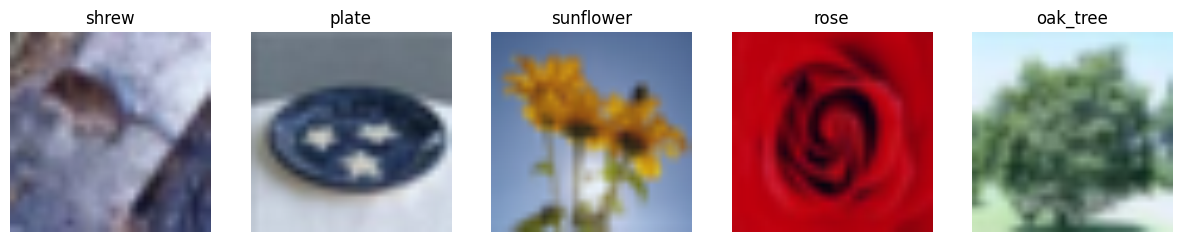

In [ ]:
# define a function to display several images in the dataset
def display_dataset(dataset, n = 100,classes = None):
    fig, ax = plt.subplots(1, n, figsize = (15, 3))
    mn = min([dataset[i][0].min() for i in range(n)]) # scale the pixel values for display
    mx = max([dataset[i][0].max() for i in range(n)]) # scale the pixel values for display
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0] - mn)/(mx - mn), (1, 2, 0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])

# display several example images
display_dataset(train_ds, n = 5, classes = cifar100_classes)

### Task 2. Load Pre-trained model and Re-build the classifier

<span style="color:red">**[TBC]**</span> You need to:
- Load the pre-trained Squeeze Net
- Replace the `classifier` part
- Freeze the `features` part
- Set up GPU acceleration

In [ ]:
# load pre-trained SqueezeNet 1.1 model
squeezenet = models.squeezenet1_1(pretrained = True)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 101MB/s]

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

In [ ]:
# replace the classifier part
squeezenet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(10000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(1000), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
    nn.LazyLinear(100)
)
# print network structure
print(f"Model structure:\n{squeezenet}\n")

Model structure:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
 

In [ ]:
# freeze the learning parameters of the feature extractor part
for parameter in squeezenet.features.parameters():
    parameter.requires_grad = False

In [ ]:
# move the model to the computation device
squeezenet = squeezenet.to(device)

### Task 3. Train the re-built classifier

<span style="color:red">**[TBC]**</span> You need to:

- Define a `train()` function
- Specify the training hyper-parameters
- Train the network (only the classifier part)
- Plot the loss history of the training process

In [ ]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()

    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y = X.to(device), y.to(device)
            logits = model(X)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y = X.to(device), y.to(device)
                logits = model(X)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            patience_counter = 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [ ]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    squeezenet.classifier.parameters(), # only optimize the classifier part
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 50
early_stopping_patience = 5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 1
)
saved_path_prefix = 'finetuned_classifier_squeezenet'

In [ ]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    squeezenet, # specify which model to train
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Epoch 1: train loss = 2.466745, val loss = 1.838952, time consumed = 0:02:53
Model saved after epoch 1



Validation batch: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Epoch 2: train loss = 1.218495, val loss = 1.491980, time consumed = 0:06:34
Model saved after epoch 2



Validation batch: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Epoch 3: train loss = 0.659662, val loss = 1.452390, time consumed = 0:10:08
Model saved after epoch 3



Validation batch: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Epoch 4: train loss = 0.323365, val loss = 1.339138, time consumed = 0:13:47
Model saved after epoch 4



Validation batch: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


Epoch 5: train loss = 0.159953, val loss = 1.303230, time consumed = 0:17:27
Model saved after epoch 5



Validation batch: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Epoch 6: train loss = 0.090565, val loss = 1.313820, time consumed = 0:23:29


Validation batch: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Epoch 7: train loss = 0.060394, val loss = 1.313523, time consumed = 0:26:25
Learning rate reduced after epoch 7



Validation batch: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Epoch 8: train loss = 0.044714, val loss = 1.271578, time consumed = 0:29:20
Model saved after epoch 8



Validation batch: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Epoch 9: train loss = 0.040326, val loss = 1.267521, time consumed = 0:34:14
Model saved after epoch 9



Validation batch: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Epoch 10: train loss = 0.038715, val loss = 1.266093, time consumed = 0:39:00
Model saved after epoch 10



Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


Epoch 11: train loss = 0.036878, val loss = 1.266362, time consumed = 0:44:18


Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Epoch 12: train loss = 0.035165, val loss = 1.265289, time consumed = 0:47:23
Model saved after epoch 12



Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Epoch 13: train loss = 0.034250, val loss = 1.265602, time consumed = 0:52:11


Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Epoch 14: train loss = 0.033094, val loss = 1.266840, time consumed = 0:55:19
Learning rate reduced after epoch 14



Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Epoch 15: train loss = 0.032059, val loss = 1.264725, time consumed = 0:58:24
Model saved after epoch 15



Validation batch: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


Epoch 16: train loss = 0.031207, val loss = 1.264715, time consumed = 1:03:58
Model saved after epoch 16



Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Epoch 17: train loss = 0.032442, val loss = 1.265647, time consumed = 1:08:56
Learning rate reduced after epoch 17



Validation batch: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


Epoch 18: train loss = 0.031267, val loss = 1.265342, time consumed = 1:12:02


Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


Epoch 19: train loss = 0.031247, val loss = 1.265110, time consumed = 1:15:07
Learning rate reduced after epoch 19



Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Epoch 20: train loss = 0.031133, val loss = 1.265190, time consumed = 1:18:12


Validation batch: 100%|██████████| 20/20 [00:32<00:00,  1.60s/it]

Epoch 21: train loss = 0.031709, val loss = 1.267345, time consumed = 1:21:19
Learning rate reduced after epoch 21

Early stopping!


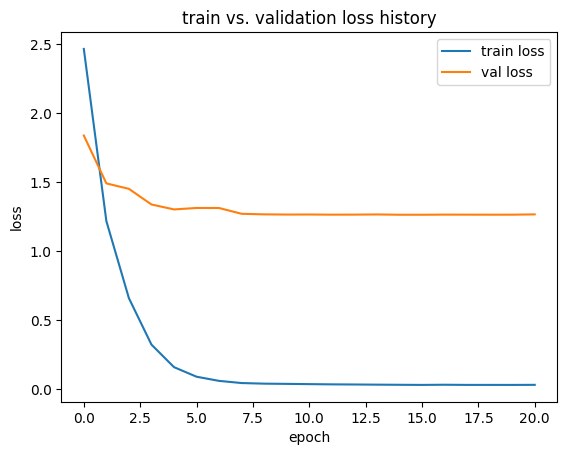

In [ ]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Task 4. Reload the best model

<span style="color:red">**[TBC]**</span> You need to:

- Reload the best model saved during the training process

In [ ]:
# reload the best model
squeezenet.load_state_dict(torch.load(saved_path))
squeezenet.to(device)

<ipython-input-17-c41b6bae7a34>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  squeezenet.load_state_dict(torch.load(saved_path))


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

### Task 5. Evaluation using the test set

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [ ]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in tqdm(dataloader, desc = f'Test batch'):
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [ ]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, squeezenet, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred, target_names = cifar100_classes))

Test batch: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


test loss = 1.2528460264205932
               precision    recall  f1-score   support

        apple       0.86      0.83      0.85       100
aquarium_fish       0.73      0.78      0.75       100
         baby       0.49      0.50      0.50       100
         bear       0.47      0.37      0.41       100
       beaver       0.50      0.48      0.49       100
          bed       0.66      0.70      0.68       100
          bee       0.72      0.73      0.73       100
       beetle       0.77      0.67      0.72       100
      bicycle       0.89      0.77      0.82       100
       bottle       0.85      0.82      0.83       100
         bowl       0.65      0.56      0.60       100
          boy       0.48      0.42      0.45       100
       bridge       0.71      0.70      0.70       100
          bus       0.59      0.54      0.57       100
    butterfly       0.69      0.61      0.65       100
        camel       0.57      0.55      0.56       100
          can       0.78      0.7

The predicted class is: crab
The predicted probability is: 0.33827835


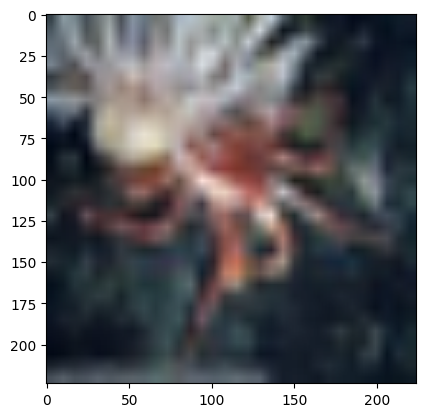

In [ ]:
# display an example
sample = test_ds[100][0].numpy().transpose(1, 2, 0)
mn = sample.min()
mx = sample.max()
plt.imshow((sample - mn)/(mx - mn))
print('The predicted class is:', cifar100_classes[test_pred[100]])
print('The predicted probability is:', test_prob[100, test_pred[100]])